In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
import matplotlib.pyplot as plt

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
#https://github.com/bp-kelley/descriptastorus


# Input both test/training dataset 

In [189]:
full_copy = pd.read_csv('../../../project1_data/Series4_full.csv', index_col = 'ID')
# full_copy.head()
PandasTools.AddMoleculeColumnToFrame(full_copy,smilesCol='SMILES')
# full_copy.head()

# Generating descriptors using RDKit

In [190]:
# RDKit
generator = MakeGenerator(("RDKit2D",))

full_copy_rdkit2d = [generator.process(x)[1:] for x in full_copy['SMILES']]

In [191]:
rdkit2d_name = []
for name, numpy_type in generator.GetColumns():
    rdkit2d_name.append(name)
    
full_copy_rdkit2d_df = pd.DataFrame(full_copy_rdkit2d, index = full_copy.index, columns=rdkit2d_name[1:])

In [6]:
# full_copy_rdkit2d_df.head()

# MACCS keys 

In [7]:
# full_copy_MAACS = [MACCSkeys.GenMACCSKeys(x) for x in full_copy['ROMol']]
# full_copy_MAACS_list = [list(l) for l in full_copy_MAACS]
# maccs_name = [f'Bit_{i}' for i in range(167)]
# full_copy_MAACS_df = pd.DataFrame(full_copy_MAACS_list, index = full_copy.index, columns=maccs_name)
# full_copy_MAACS_df

In [8]:
# Mergind MACCS and RDKit descriptors

# full_copy_rdkit2d_df = pd.merge(full_copy_MAACS_df,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# full_copy_rdkit2d_df.shape

In [192]:
full_copy_rdkit2d_df.to_csv('../../../project1_data/from_PP/full_copy_rdkit2d_df.csv')

In [193]:
TrainTest=full_copy.drop(full_copy[full_copy.type == 'validation'].index)
TrainTest.drop(TrainTest[TrainTest.type == 'excluded'].index, inplace=True)
TrainTest.drop(TrainTest[TrainTest.type == 'excluded_subset'].index, inplace=True)

# full_copy.shape
validation=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
validation.drop(validation[validation.type == 'excluded'].index, inplace=True)
validation.drop(validation[validation.type == 'excluded_subset'].index, inplace=True)

excluded=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
excluded.drop(excluded[excluded.type == 'validation'].index, inplace=True)
excluded.drop(excluded[excluded.type == 'excluded'].index, inplace=True)


# TrainTest.head()

# Including PP data

In [202]:
full_copy_rdkit2d_df = pd.read_csv('../../../project1_data/from_PP/desirable-database_2020-09-10_ONLY-PPP-descriptors.csv', index_col = 'ID')
full_copy_rdkit2d_df.head()
allMerged = pd.merge(TrainTest,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged_validation = pd.merge(validation,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged_excluded = pd.merge(excluded,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged.shape

(196, 173)

In [203]:
allMerged.drop(['type','desired_type',  'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
allMerged_validation.drop(['type', 'desired_type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
allMerged_excluded.drop(['type', 'desired_type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
# allMerged.dropna(inplace=True)

allMerged.drop(['desired'], axis=1, inplace=True)
allMerged_validation.drop(['desired'], axis=1, inplace=True)
# allMerged_validation.drop(allMerged_validation[allMerged_validation.clearance < 7].index, inplace=True)
allMerged_excluded.drop(['desired'], axis=1, inplace=True)
allMerged_excluded.drop(allMerged_excluded[allMerged_excluded.clearance < 7].index, inplace=True)

# allMerged.drop(['clearance'], axis=1, inplace=True)
# allMerged_validation.drop(['clearance'], axis=1, inplace=True)
# allMerged_excluded.drop(['clearance'], axis=1, inplace=True)

# allMerged.drop(allMerged[allMerged.clearance > 49.9].index, inplace=True)
# allMerged.drop(allMerged[allMerged.desired < 4.6].index, inplace=True)
# allMerged.drop(allMerged[allMerged.clearance < 0.51].index, inplace=True)
# allMerged[allMerged['clearance'] > 49.9 ]


In [208]:
# allMerged

,SMILES,clearance,logS_SD,logS_7_4,logP_SD,logD_SD,2C9_pKi,hERG,BBB_log_SD,BBB,...,RotBonds,ALogP,ALogP_MR,Wiener,Zagreb,Num_H_Acceptors,Num_H_Donors,Molecular_Volume,Molecular_SurfaceArea,Molecular_PolarSurfaceArea
ID,,,,,,,,,,,,,,,,,,,,,
DDD02153544,C1CC(CCn2cncn2)CN(C1)c1snc2ccccc12,16.070,2.456,1.713,3.441,1.954,4.946,6.168,-0.440,0.75,...,4,3.086,92.432,1130,118,4,0,244.21,315.30,75.08
DDD01868260,C1C[C@H](CN(C1)c1snc2ccccc12)Cn1ccnc1,5.992,2.169,1.324,3.645,2.041,5.047,6.095,-0.307,0.17,...,3,2.763,87.794,954,114,3,0,234.61,300.30,62.19
DDD02156129,C1CC(CCn2ccnn2)CN(C1)c1snc2ccccc12,13.000,2.456,1.713,3.441,1.960,4.946,6.167,-0.440,0.75,...,4,3.303,93.089,1130,118,4,0,243.18,311.12,75.08
DDD02157535,CC(=O)N[C@@H]1CCCN(C1)c1snc2ccc(cc12)F,3.926,2.633,1.278,2.687,1.564,5.067,5.188,-0.671,0.21,...,2,2.353,78.523,814,106,3,1,230.49,288.83,73.47
DDD02155725,F[C@@H]1C[C@H](CN(C1)c1snc2ccccc12)NC(=O)c1ncc...,12.700,2.442,1.245,2.160,1.590,5.082,4.772,-0.800,0.97,...,3,1.955,90.538,1368,130,4,2,249.01,327.70,102.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DDD02098186,C1CCN(C1)CC1CCCN(C1)c1snc2ccccc12,29.870,3.109,1.384,3.678,2.630,4.520,6.552,0.063,0.14,...,3,3.621,91.413,954,114,3,0,248.33,306.36,47.61
DDD01865290,O[C@@H]1CCN(C1)c1snc2ccccc12,2.797,4.206,1.350,1.822,1.266,4.416,5.258,-0.634,0.20,...,1,1.836,62.562,348,82,3,1,171.49,211.79,64.59
DDD02155729,Cn1cnc(c1)C(=O)N[C@H]1CN(CC[C@H]1F)c1snc2ccccc12,1.511,2.270,1.385,2.852,1.563,5.439,5.376,-0.632,0.95,...,3,2.183,95.586,1546,136,4,1,272.68,353.57,91.29


# Random forest 

In [224]:
X = allMerged.iloc[:, 2:,].values #descreptors
y = allMerged.iloc[:, 1].values #desired property
# y


0.593939393939394

In [218]:
# print(X.shape)
# print(y)

r2_list = []
random_state_variable_list = []

for f in range(0,1,1):

    random_state_variable=f
    random_state_variable_list.append(f)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_variable)
    print(X_train.shape)
    # print(X_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)

    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train.shape

    ### Starting Random Forest fitting

    from sklearn.ensemble import RandomForestRegressor

    regressor = RandomForestRegressor(n_estimators=500, random_state=random_state_variable)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    from sklearn import metrics

#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
#     from sklearn.metrics import r2_score
#     plt.scatter(y_test, y_pred)
#     m, b = np.polyfit(y_test, y_pred, 1)
#     plt.plot(y_test, m*y_test + b)
#     # plt.axes.set_title()
#     plt.title('R2: ' + str(r2_score(y_test, y_pred)))

print (random_state_variable_list)
print (r2_list)

(156, 163)
[0]
[0.6657482374788939]


(40,)

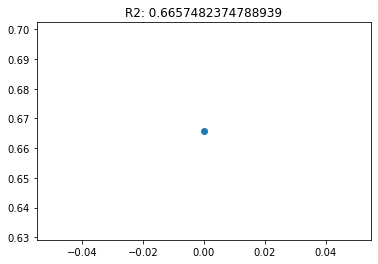

In [227]:
from sklearn.metrics import r2_score
plt.scatter(random_state_variable_list, r2_list)
plt.title('R2: ' + str(r2_score(y_test, y_pred)))

Mean Absolute Error: 5.346666247448979
Mean Squared Error: 48.21028288188405
Root Mean Squared Error: 6.943362505435248
XXXXXXXXXXXXXXXXXXXXX


Text(0.5, 1.0, 'R2: 0.6657482374788939')

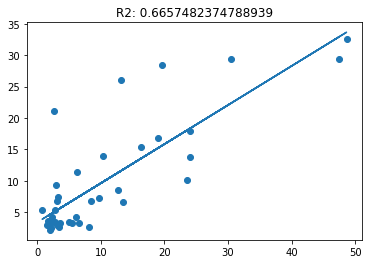

In [226]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, Y_valid_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, Y_valid_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, Y_valid_pred)))
print('XXXXXXXXXXXXXXXXXXXXX')
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
plt.title('R2: ' + str(r2_score(y_test, y_pred)))

# Validation datasets

In [220]:
X_valid = allMerged_validation.iloc[:, 2:,].values #descreptors
y_valid = allMerged_validation.iloc[:, 1].values #desirable data

# allMerged_excluded.dropna(inplace=True)
# X_valid = allMerged_excluded.iloc[:, 2:,].values #descreptors
# y_valid = allMerged_excluded.iloc[:, 1].values #desirable data

X_valid.shape
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_valid_norm = sc.fit_transform(X_valid)
X_valid_norm.shape
# allMerged_excluded.dropna(inplace=True)
# allMerged_excluded

(14, 163)

Mean Absolute Error: 5.346666247448979
Mean Squared Error: 48.21028288188405
Root Mean Squared Error: 6.943362505435248
XXXXXXXXXXXXXXXXXXXXX


Text(0.5, 1.0, 'R2: 0.6718290885101952')

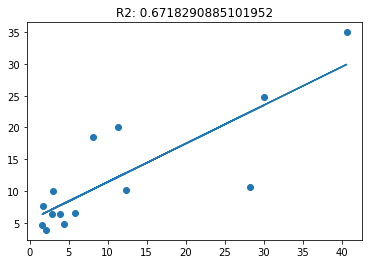

In [221]:
Y_valid_pred = regressor.predict(X_valid_norm)
# print(X_valid_norm)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, Y_valid_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, Y_valid_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, Y_valid_pred)))
print('XXXXXXXXXXXXXXXXXXXXX')
plt.scatter(y_valid, Y_valid_pred)
m, b = np.polyfit(y_valid, Y_valid_pred, 1)
plt.plot(y_valid, m*y_valid + b)
plt.title('R2: ' + str(r2_score(y_valid, Y_valid_pred)))

# Visualising leaves

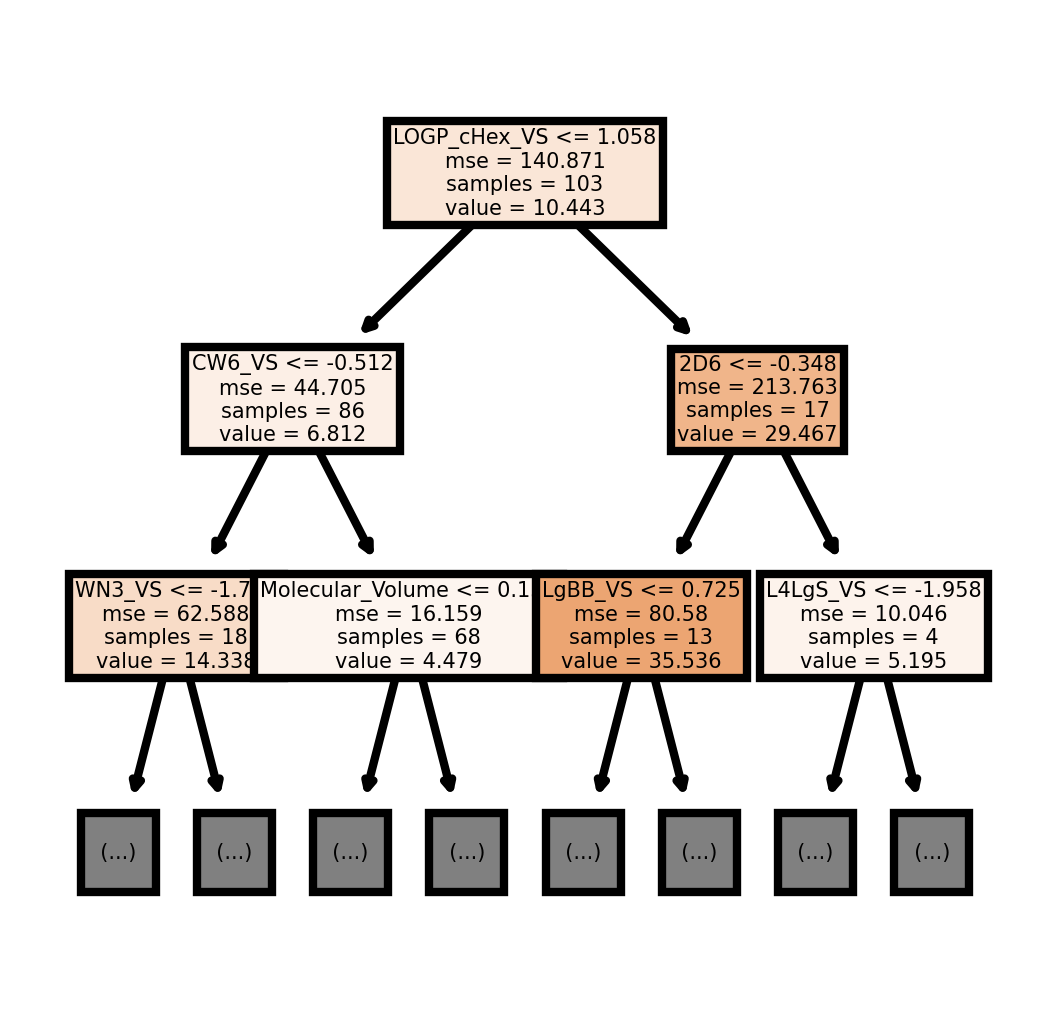

In [233]:
estimator = regressor.estimators_[2]

# print(estimator.feature_importances_)

allMerged.columns[2:]
allMerged.columns[1]


fn=allMerged.columns[2:]
cn=allMerged.columns[1]
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=600)
tree.plot_tree(estimator,
               feature_names = fn, 
               class_names=cn,
               filled = True,
               max_depth=2,
               fontsize = 2.5);
fig.savefig('RandomForest_PP_Clearance_classifier.png')